## Bussiness Understanding






**Latar Belakang**

Perusahaan multifinance ingin mengurangi kerugian akibat gagal bayar. Kita membuat model sederhana untuk memprediksi risiko kredit saat pengajuan agar keputusan approve/reject lebih tepat.

**Rumusan Masalah (Tujuan Analitik)** : Memberi sinyal risiko kepada underwriting/ops dan manajemen risiko supaya keputusan awal lebih akurat dan kerugian berkurang.

**Ruang lingkup dan batasan**
1. Unit prediksi: 1 aplikasi pinjaman jadi 1 prediksi
2. Cakupan data: mencakup pinjaman disetujui dan ditolak (mengacu Data Dictionary sebagai sumber definisi kolom).
*   BAD (1): Charged Off, Default, Late (31–120 days).
*   GOOD (0): Fully Paid.
*  Tidak dipakai untuk training: Current, In Grace Period, Late (16–30 days) dan status ambigu.
3. Menghindari penggunaan kolom yang mencerminkan informasi setelah pengajuan (potensi data leakage, mis. metrik pembayaran aktual).
4. Ketersediaan fitur: hanya menggunakan fitur yang tersedia saat pengajuan

**Pendekatan Pemodelan**
1.   Menggunakan minimal dua algoritma sesuai ketentuan, termasuk Logistic Regression (wajib) dan Decision Tree sebagai pembanding.
2.   Pembagian data ke train/test untuk evaluasi yang adil.
3.   Encoding untuk variabel kategorikal dan penanganan nilai hilang dilakukan sebelum pelatihan model.

**Metrik keberhasilan** :
1.   Pelaporan metrik pada test set: Accuracy, Precision, Recall, F1, ROC-AUC, disertai Confusion Matrix dan Classification Report
2.   Perbandingan terhadap baseline (mis. prediksi kelas mayoritas) untuk memastikan ada peningkatan yang berarti.
3.  Karena kelas BAD lebih sedikit (imbalanced), fokus evaluasi pada kelas positif = BAD (1).



## Data Understanding

In [ ]:
#Import library pada python yang akan digunakan nanti.
import os
import re
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Untuk nampilin sampai 200 kolom agar tabel tidak terpotong.
pd.set_option("display.max_columns", 200)
# Mengatur lebar dari dataframe
pd.set_option("display.width", 180)
# Agar hasil pembagian data (train-test split) tetap sama dari satu run ke run berikutnya.
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Rakamin Final Task/loan_data_2007_2014.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)

In [ ]:
# Untuk mengecek pada shape dataset dan juga 5 baris data teratas.
print("Shape :", df.shape)
display(df.head(5))


Shape : (466285, 75)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Pada dataset terdapat kolom loan_status yang akan dijadikan sebagai atribut target
* Setelah dilakukan pengecekan terdapat 466.285 baris (records) dan 75 atribut (features) dari dataset tersebut.
* Beberapa atribut mengandung data yang hilang (NaN), misalnya emp_title, desc, mths_since_last_delinq, mths_since_last_record, annual_inc_joint, dti_joint, dll.
* Pada beberapa kolom akan diubah seperti:

1.   Feature tansformation pada kolom term
2.   Feature engineering pada kolom emp_length
3.   Datetime parsing + feature engineering pada kolom earliest_cr_line & issue_d
4.  Normalization pada purpose
5.  Feature Selection pada id, member_id, url, desc, title, zip_code





In [ ]:
# Dilakukan untuk melihat type data apa yang ada pada dataset
display(df.dtypes.value_counts())

,count
float64,46
object,22
int64,7


* Didapatkan hasil pada type datanya dengan float sebanyak 46 kolom, object sebanyak 22 kolom dan int64 sebanyak 7 kolom

In [ ]:
"""
Agar tahu seberapa besar penggunaan ram terhadap dataset jika
terlalu besar akan di sesuaikan kembali dan juga untuk cek info
pada dataset seperti data hilang dan type datanya.
"""
df.info(memory_usage="deep")
memu = df.memory_usage(deep=True).sum()/(1024**2)
print(f"\n Estimated: {memu:.2f} MB")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

* Diketahu jika total penggunaan memori sekitar 780 MB.
* Beberapa kolom terisi penuh misalnya id, loan_amnt , namun banyak atribut memiliki missing value.
* Kolom dengan data hilang sebagian antara lain seperti emp_title, emp_length, desc , dan mths_since_last_delinq, dll. Data yang hilang kemungkinan tidak akan terpakai dan akan dihapus.
* Ada juga atribut yang seluruhnya kosong seperti annual_inc_joint, dti_joint, verification_status_joint, open_acc_6m, open_il_6m, dll.
* Beberapa kolom yang "Leakage" akan dihapus karena akan mengetahui setelah pinjaman berjalan seperti total_pymnt, total_y,emt_innv dan lainnya


In [ ]:
# Mengecek data yang duplicate dengan bantuan library
duplicated = df.duplicated().sum()
print("Jumlah baris duplikat:",duplicated)

Jumlah baris duplikat: 0


Tidak ada baris data yang duplicate

In [ ]:
# Mengecek jumlah data yang hilang dengan persentasenya dari dengan DESC
print("\n==[ DU-3 ] Missing Values (Top 25) ==")
data_hilang = (df.isna().sum().sort_values(ascending=False)).to_frame("missing")
data_hilang["percent_missing"] = (data_hilang["missing"] / len(df) * 100).round(2)
try:
    display(data_hilang.head(25))
except Exception:
    print(data_hilang.head(25))


==[ DU-3 ] Missing Values (Top 25) ==


,missing,percent_missing
max_bal_bc,466285,100.00
open_rv_24m,466285,100.00
inq_fi,466285,100.00
open_rv_12m,466285,100.00
il_util,466285,100.00
mths_since_rcnt_il,466285,100.00
total_bal_il,466285,100.00
open_il_24m,466285,100.00
open_il_12m,466285,100.00
open_il_6m,466285,100.00


Terdapat data yang hilang semuanya sangat banyak sekitar >10 dan juga data yang hilang lebih dari 40$ sekitar >5 yang nanti akan di drop supaya tidak menggangu pada Data Preperation

In [ ]:
# Menampilkan data hilang total dengan kolom.
data_hilang_total = [c for c in df.columns if df[c].isna().all()]
print("\nNA=100% (rencana drop di Data Preparation):", len(data_hilang_total))
print(data_hilang_total)



NA=100% (rencana drop di Data Preparation): 17
['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']


Data yang hilang total ada 17 kolom antara lain : 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

In [ ]:
# Menampilkan data hilang dengan persentase diatas 40% dengan kolom.
print("\n missing value dengan nilai persentase diatas 40%")
data_hilang_40 = (df.isna().mean() * 100).round(2)
try:
    display(data_hilang_40[data_hilang_40 > 40].sort_values(ascending=False).to_frame("percent_missing"))
except Exception:
    print(data_hilang_40[data_hilang_40 > 40].sort_values(ascending=False))


 missing value dengan nilai persentase diatas 40%


,percent_missing
annual_inc_joint,100.00
open_il_12m,100.00
open_il_6m,100.00
open_acc_6m,100.00
verification_status_joint,100.00
dti_joint,100.00
il_util,100.00
open_rv_12m,100.00
open_rv_24m,100.00
max_bal_bc,100.00


In [ ]:

print("\n Statistik numerik  ==")
numeric_col = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_col:
    try:
        display(df[numeric_col].describe().T)
    except Exception:
        print(df[numeric_col].describe().T)
else:
    print("Tidak ada kolom numerik.")


 Statistik numerik  ==


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,466285.0,2.331420e+05,1.346050e+05,0.00,1.165710e+05,2.331420e+05,3.497130e+05,4.662840e+05
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01




*   Ditemukan nilai maksimum yang ekstrem pada
annual_inc hingga 7,500,000, revol_bal hingga 2,568,995, total_rev_hi_lim hingga 9,999,999, tot_coll_amt hingga 9,152,545.




In [ ]:

print("== Red Flags Numerik ==")
amount_cols = [c for c in numeric_col if any(k in c.lower() for k in ["amt","amount","balance","fund","loan"])]
percent_cols = [c for c in numeric_col if any(k in c.lower() for k in ["pct","percent","util","rate"])]

neg_amount = {c: int((df[c] < 0).sum()) for c in amount_cols if (df[c] < 0).any()}
over100_pct = {c: int((df[c] > 100).sum()) for c in percent_cols if (df[c] > 100).any()}

print("Nilai amount negatif (baris per kolom):", {k:v for k,v in neg_amount.items() if v>0})
print("Nilai persentase >100 (baris per kolom):", {k:v for k,v in over100_pct.items() if v>0})


== Red Flags Numerik ==
Nilai amount negatif (baris per kolom): {}
Nilai persentase >100 (baris per kolom): {'revol_util': 1292}


*   Nilai amount negatif tidak ditemukan pada kolom-kolom amount/balance yang dicek
*   revol_util memiliki 1,292 baris >100 yang akan di clip revol_util ke [0, 100].





In [ ]:

print("\n==Ringkasan kategorikal & cardinality ==")
category_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Jumlah kolom kategorikal:", len(category_cols))

for c in ["term", "grade", "sub_grade"]:
    if c in df.columns:
        print(f"\nValue counts — {c} (top 10):")
        vc = df[c].value_counts(dropna=False).head(10)
        try:
            display(vc)
        except Exception:
            print(vc)


if category_cols:
    card = df[category_cols].nunique(dropna=False).sort_values(ascending=False)
    print("\nCardinality kategorikal (top 10):")
    try:
        display(card.head(10).to_frame("nunique"))
    except Exception:
        print(card.head(10))

const_cols = [c for c in df.columns if df[c].nunique(dropna=True) <= 1]
print("\nKolom konstan/nyaris konstan:", const_cols)


==Ringkasan kategorikal & cardinality ==
Jumlah kolom kategorikal: 22

Value counts — term (top 10):


,count
term,
36 months,337953
60 months,128332



Value counts — grade (top 10):


,count
grade,
B,136929
C,125293
D,76888
A,74867
E,35757
F,13229
G,3322



Value counts — sub_grade (top 10):


,count
sub_grade,
B3,31686
B4,30505
C1,26953
C2,26740
B2,26610
C3,25317
B5,25252
C4,24105
B1,22876



Cardinality kategorikal (top 10):


,nunique
url,466285
emp_title,205476
desc,124436
title,63099
zip_code,888
earliest_cr_line,665
last_credit_pull_d,104
next_pymnt_d,101
last_pymnt_d,99
issue_d,91



Kolom konstan/nyaris konstan: ['policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']




*   term hanya 36 months dan 60 months hal tersebut dapat memudahkan konversi ke numerik
*   grade terdapat 7 level dari A–G, dengan dominan B, C yang ordinal dapat diubah untuk hot encoding



In [ ]:
# Cek loan status dan juga membuat label baru pada status gtood dan bad.
print("\n== Distribusi loan_status (preview) ==")
if "loan_status" in df.columns:
    ls_counts = df["loan_status"].value_counts()
    try:
        display(ls_counts.head(10))
    except Exception:
        print(ls_counts.head(10))

    # definisi label untuk tahap modelling
    Good_Status = {"Fully Paid"}
    Bad_Status  = {"Charged Off", "Default", "Late (31-120 days)"}
    mask_label = df["loan_status"].isin(Good_Status | Bad_Status)
    print("\nPreview kandidat baris untuk modelling (GOOD/BAD)")
    print("  - Total kandidat:", int(mask_label.sum()))
    print("  - BAD (1):", int(df["loan_status"].isin(Bad_Status).sum()))
    print("  - GOOD (0):", int(df["loan_status"].isin(Good_Status).sum()))



== Distribusi loan_status (preview) ==


,count
loan_status,
Current,224226
Fully Paid,184739
Charged Off,42475
Late (31-120 days),6900
In Grace Period,3146
Does not meet the credit policy. Status:Fully Paid,1988
Late (16-30 days),1218
Default,832
Does not meet the credit policy. Status:Charged Off,761



Preview kandidat baris untuk modelling (GOOD/BAD)
  - Total kandidat: 234946
  - BAD (1): 50207
  - GOOD (0): 184739


Baseline majority accuracy kurang lebuh 78.63% yang menebak kelas terbanyak nya itu good. yang menjadikan patokan model yang baik harus melampaui metrik operasional

In [ ]:
print("\n==Preview tanggal ==")
if "issue_d" in df.columns:
    issue = pd.to_datetime(df["issue_d"], format="%b-%y", errors="coerce")
    print("issue_d  -> min:", issue.min(), "| max:", issue.max(), "| NaT%:", round(issue.isna().mean(), 3))
else:
    print("Kolom 'issue_d' tidak ditemukan.")

if "earliest_cr_line" in df.columns:
    ear = pd.to_datetime(df["earliest_cr_line"], format="%b-%y", errors="coerce")
    print("earliest -> min:", ear.min(),   "| max:", ear.max(),   "| NaT%:", round(ear.isna().mean(), 3))
else:
    print("Kolom 'earliest_cr_line' tidak ditemukan.")


==Preview tanggal ==
issue_d  -> min: 2007-06-01 00:00:00 | max: 2014-12-01 00:00:00 | NaT%: 0.0
earliest -> min: 1969-01-01 00:00:00 | max: 2068-12-01 00:00:00 | NaT%: 0.0


In [ ]:

print("\n== Top konsumsi memori per kolom ==")
memory_cols = df.memory_usage(deep=True).sort_values(ascending=False)
try:
    display((memory_cols.head(12) / (1024**2)).round(2).to_frame("MB"))
except Exception:
    print((memory_cols.head(12) / (1024**2)).round(2).head(12))



== Top konsumsi memori per kolom ==


,MB
url,52.22
desc,45.19
title,29.48
purpose,28.45
emp_title,28.35
verification_status,26.91
term,26.24
application_type,26.24
loan_status,25.81
emp_length,24.71


In [ ]:
print("\ Catatan rencana untuk Data Preparation  ==")

leaked_cols = [
    "funded_amnt","funded_amnt_inv","out_prncp","out_prncp_inv",
    "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee",
    "recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt",
    "next_pymnt_d","last_credit_pull_d"
]
print("Contoh kolom leakage (akan di-drop saat DP):", leaked_cols)

print("\n[Data Understanding — SIMPLE] Selesai. df TIDAK diubah pada tahap ini.")

\ Catatan rencana untuk Data Preparation  ==
Contoh kolom leakage (akan di-drop saat DP): ['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d']

[Data Understanding — SIMPLE] Selesai. df TIDAK diubah pada tahap ini.


<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2684407429.py:1: SyntaxWarning: invalid escape sequence '\ '
  print("\ Catatan rencana untuk Data Preparation  ==")


## EDA (Exploratory Data Analysis)

In [ ]:
RANDOM_STATE = 42
PLOT_N = 100_000  # agar plot tetap ringan
np.random.seed(RANDOM_STATE)

In [ ]:
# Definisi label & subset EDA
Good_Status = {"Fully Paid"}
Bad_Status  = {"Charged Off", "Default", "Late (31-120 days)"}

mask_eda = df["loan_status"].isin(Good_Status | Bad_Status)
df_eda = df.loc[mask_eda].copy()              # copy untuk eksplorasi
df_eda["target"] = np.where(df_eda["loan_status"].isin(Bad_Status), 1, 0)

print(" target (GOOD=0 / BAD=1):")
print(df_eda["target"].value_counts(normalize=True).rename({0:"GOOD%",1:"BAD%"}).round(3))


 target (GOOD=0 / BAD=1):
target
GOOD%    0.786
BAD%     0.214
Name: proportion, dtype: float64


Proporsi awal pada data, setelah dicarti ternyata data pada Bad terdapat kurang lebih 21,4% dan Good kurang lebih 78,6%. Artinya, data imbalance yang mana kelas pada Bad jauh lebih sedikit dan ini perlu diingat saat evaluasi model nanti.

In [ ]:
## List kolom
numeric_col   = df.select_dtypes(include=[np.number]).columns.tolist()
category_cols = df.select_dtypes(include=["object"]).columns.tolist()

amount_cols  = [c for c in numeric_col if any(k in c.lower() for k in ["amt","amount","balance","fund","loan"])]
percent_cols = [c for c in numeric_col if any(k in c.lower() for k in ["pct","percent","util","rate"])]

leaked_cols = [
    "funded_amnt","funded_amnt_inv","out_prncp","out_prncp_inv",
    "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee",
    "recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt",
    "next_pymnt_d","last_credit_pull_d"
]
exclude_cols = ["Unnamed: 0","id","member_id","policy_code","url","desc","title","emp_title"]


Histogram fitur numerik 


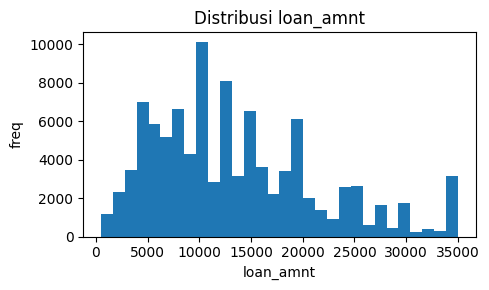

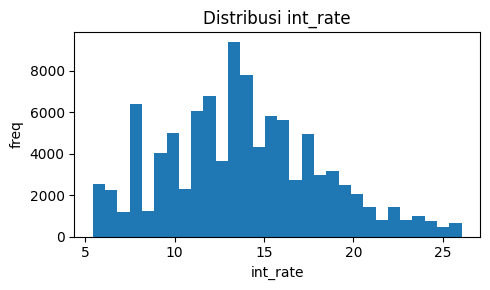

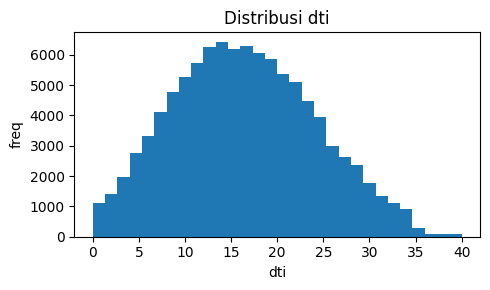

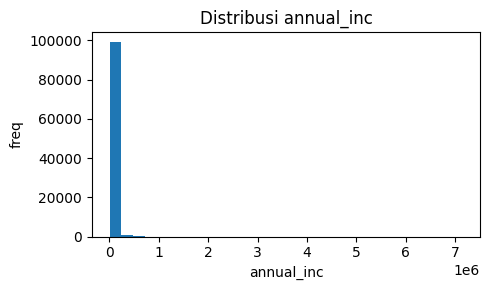

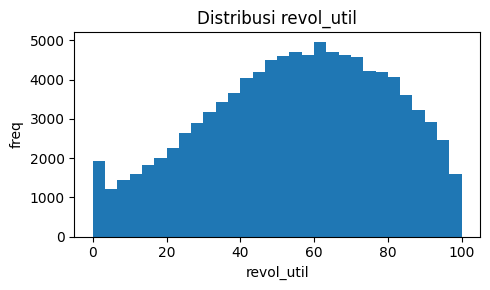

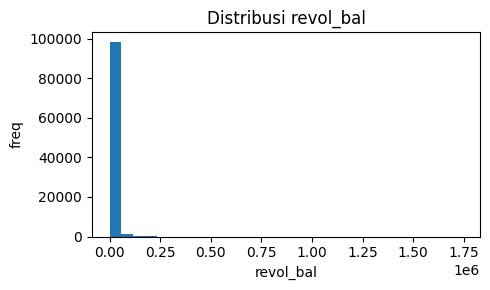

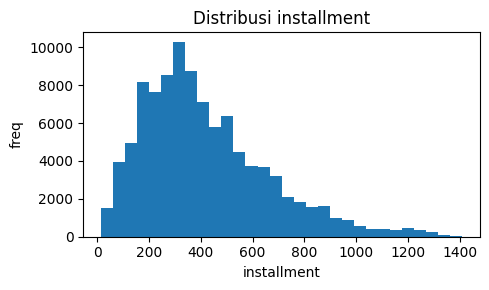

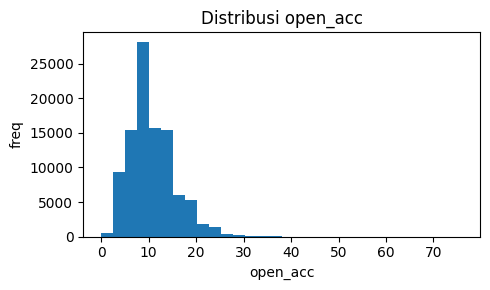

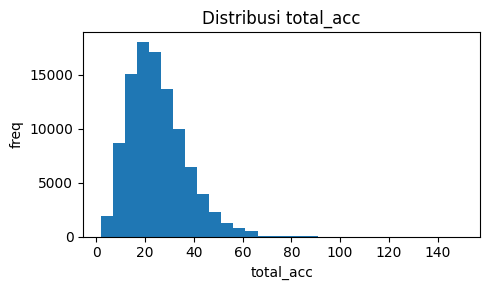

In [ ]:
# -Univariat — Numerik
plot_sample = df_eda.sample(min(len(df_eda), PLOT_N), random_state=RANDOM_STATE)

num_preview = [c for c in [
    "loan_amnt","int_rate","dti","annual_inc","revol_util",
    "revol_bal","installment","open_acc","total_acc"
] if c in df_eda.columns]

print("Histogram fitur numerik ")
for c in num_preview:
    vals = plot_sample[c].dropna().values
    if c == "revol_util":
        vals = np.clip(vals, 0, 100)
    plt.figure(figsize=(5,3))
    plt.hist(vals, bins=30)
    plt.title(f"Distribusi {c}")
    plt.xlabel(c); plt.ylabel("freq")
    plt.tight_layout()
    plt.show()


*  Pada kolom loan_amnt mayoritas berada di 8–20 ribu dengan ekor kanan hingga 35 ribu, jadi cukup distandardisasi dan waspadai kolinearitas dengan installment.

* Pada kolomint_rate rata-rata kurang lebih 13–14% dengan right-skew ringan, cukup di-scale dan perhatikan potensi multikoliner dengan grade.

* Pada kolominstallment: Q1 di angka 256, median di angka 380, Q3 di angka 566, dan max di angka1.41 , sehingga pada model linear bisa memilih installment saja atau kombinasi

* Pada kolom annual_inc median di angka 63.000, Q3 di angka 88.960, max di angka 7,5 juta terdapat outlier yang kemuungkinan akan dgunakan log1p atau winsorize sebelum scaling.





 Barplot kategori


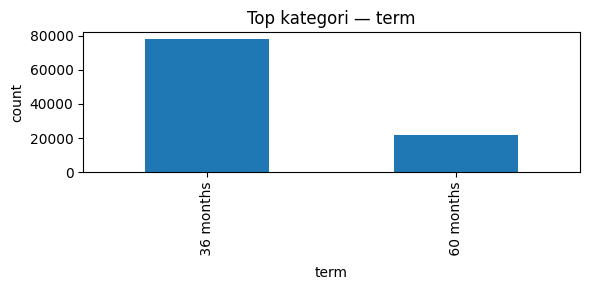

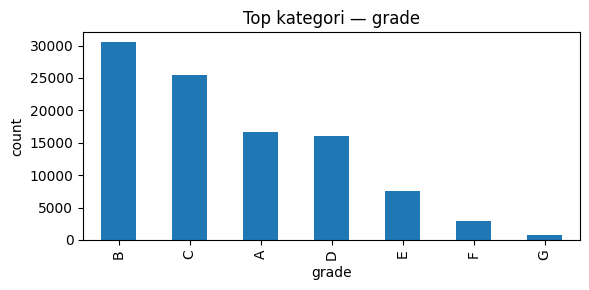

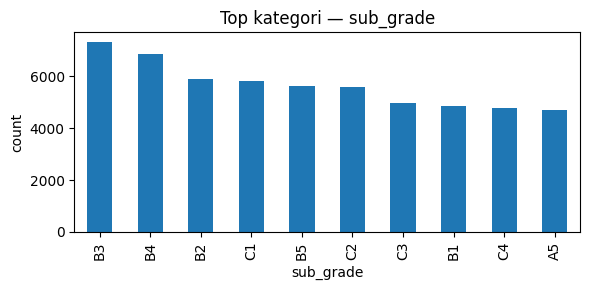

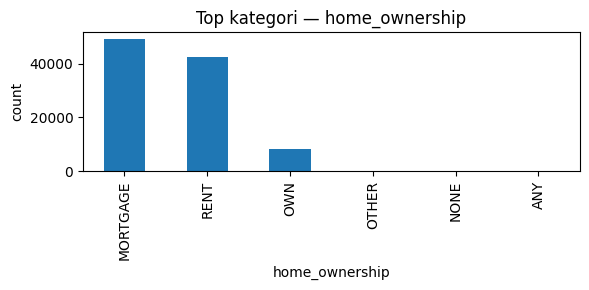

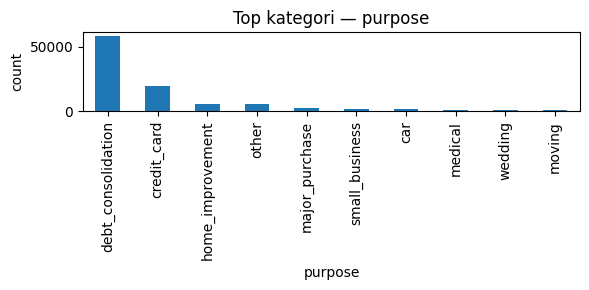

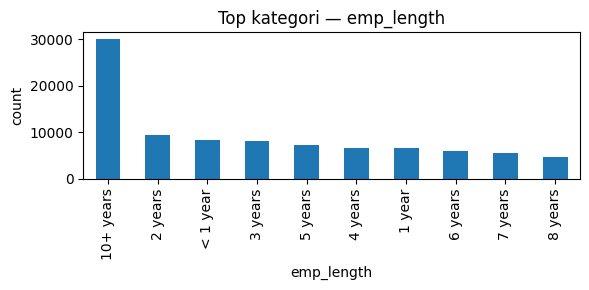

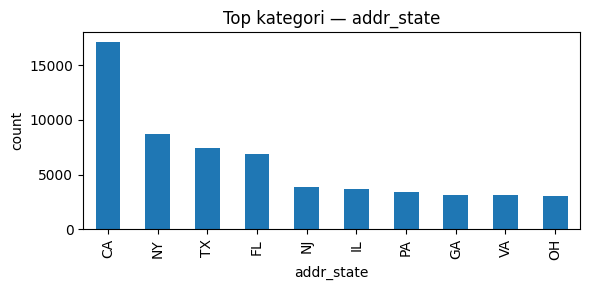

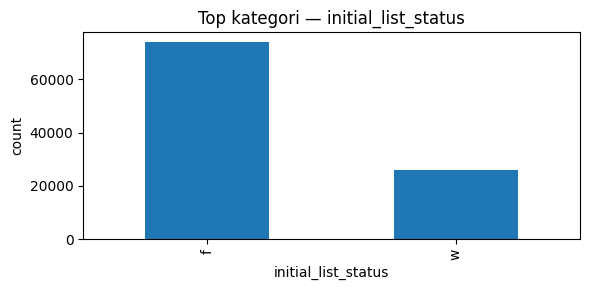

In [ ]:
# Univariat — Kategorikal
cat_preview = [c for c in [
    "term","grade","sub_grade","home_ownership","purpose",
    "emp_length","addr_state","initial_list_status"
] if c in df_eda.columns]

print(" Barplot kategori")
for c in cat_preview:
    vc = plot_sample[c].value_counts(dropna=False).head(10)
    plt.figure(figsize=(6,3))
    vc.plot(kind="bar")
    plt.title(f"Top kategori — {c}")
    plt.xlabel(c); plt.ylabel("count")
    plt.tight_layout()
    plt.show()



*   term sangat didominasi 36 months dengan 337.953 dibanding 60 months demgan 128.332.
*   grade didominasi B dengan 136.929 dan C dengan 125.293, kemudian A, D, E, F, G menurun.
* sub_grade data  terbanyak berada pada B3, B4, C1–C5, B2 dan seterusnya
* home_ownership, purpose, emp_length, addr_state, initial_list_status: distribusi terlihat masuk akal (tidak ada anomali jelas pada frekuensi).

In [ ]:
# Bivariat — BAD rate per kategori
print(" BAD rate (%) per kategori ")
for c in ["grade","term","home_ownership","purpose","emp_length","sub_grade"]:
    if c in df_eda.columns:
        tab = (df_eda.groupby(c)["target"].mean()*100).sort_values(ascending=False).round(2)
        print(f"\n[c={c}]")
        print(tab.head(10))

 BAD rate (%) per kategori 

[c=grade]
grade
G    48.11
F    44.11
E    39.17
D    30.87
C    23.71
B    14.90
A     7.34
Name: target, dtype: float64

[c=term]
term
60 months    34.92
36 months    17.55
Name: target, dtype: float64

[c=home_ownership]
home_ownership
RENT        23.55
OWN         22.55
MORTGAGE    19.30
OTHER       19.15
NONE        16.28
ANY          0.00
Name: target, dtype: float64

[c=purpose]
purpose
small_business        31.29
moving                23.94
other                 23.83
medical               22.43
debt_consolidation    22.43
renewable_energy      20.95
house                 20.62
vacation              19.97
credit_card           18.93
home_improvement      18.62
Name: target, dtype: float64

[c=emp_length]
emp_length
9 years      22.41
8 years      22.25
7 years      21.67
< 1 year     21.66
6 years      21.39
10+ years    21.00
3 years      20.68
1 year       20.58
5 years      20.46
2 years      20.36
Name: target, dtype: float64

[c=sub_grade]
sub_

* Padagrade / sub_grade bad rate meningkat dari A hingga ke G grade dapat dikatakan makin buruk yang mengkibatkan risiko gagal bayar makin tinggi.

* Pada data term 60 months cenderung bad rate lebih tinggi dibanding 36 months

In [ ]:
#  Bivariat — Statistik ringkas numerik vs target
print("Rata-rata/median fitur numerik per kelas (0=GOOD, 1=BAD):")
for c in num_preview:
    if c in df_eda.columns:
        stats = df_eda.groupby("target")[c].agg(["mean","median","std","min","max"]).round(2)
        print(f"\n[c={c}]")
        print(stats)

Rata-rata/median fitur numerik per kelas (0=GOOD, 1=BAD):

[c=loan_amnt]
            mean   median      std  min    max
target                                        
0       13214.39  11800.0  7949.03  500  35000
1       14673.70  12975.0  8383.10  900  35000

[c=int_rate]
         mean  median   std   min    max
target                                  
0       13.26   13.11  4.24  5.42  26.06
1       15.99   15.61  4.27  5.42  26.06

[c=dti]
         mean  median   std  min    max
target                                 
0       15.94   15.58  7.57  0.0  39.99
1       18.36   18.32  7.85  0.0  39.98

[c=annual_inc]
            mean   median       std     min        max
target                                                
0       73709.61  64000.0  58122.43  3000.0  7141778.0
1       65392.22  56500.0  40785.89  4080.0  1250000.0

[c=revol_util]
         mean  median    std  min    max
target                                  
0       53.73    55.2  24.86  0.0  892.3
1       59.65    



* Kolom int_rate rata-ratanya lebih tinggi pada bad .
* Pada Kolom dti data lebih tinggi pada BAD
* Pada Kolom annual_inc data lebih rendah pada BAD yang diartikan pendapatan kecil mengkibatkan resiko bayar lebih tinggi
* Kolom revol_util lebih tinggi pada BAD


In [ ]:

num_for_corr = [c for c in numeric_col if c not in set(leaked_cols + exclude_cols + ["target"])]
if len(num_for_corr) > 0:
    corr_to_target = df_eda[num_for_corr].corrwith(df_eda["target"]).dropna()
    corr_to_target = corr_to_target.reindex(corr_to_target.abs().sort_values(ascending=False).index)
    print(" Korelasi numerik vs target :")
    print(corr_to_target.head(10).round(3))

 Korelasi numerik vs target :
int_rate                  0.255
dti                       0.129
revol_util                0.099
tot_cur_bal              -0.077
loan_amnt                 0.074
annual_inc               -0.062
total_rev_hi_lim         -0.055
installment               0.055
inq_last_6mths            0.053
mths_since_last_record    0.032
dtype: float64


In [ ]:

iqr_cols = [c for c in ["int_rate","dti","annual_inc","revol_util","loan_amnt","installment"] if c in df_eda.columns]
print("Perkiraan outlier (IQR) pada kolom kunci:")
for c in iqr_cols:
    s = df_eda[c].dropna()
    if c == "revol_util":
        s = s.clip(lower=0)
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    rate = ((s < low) | (s > high)).mean() * 100
    print(f"  - {c}: ~{rate:.2f}% outlier (perkiraan)")

Perkiraan outlier (IQR) pada kolom kunci:
  - int_rate: ~0.68% outlier (perkiraan)
  - dti: ~0.08% outlier (perkiraan)
  - annual_inc: ~4.87% outlier (perkiraan)
  - revol_util: ~0.00% outlier (perkiraan)
  - loan_amnt: ~3.10% outlier (perkiraan)
  - installment: ~2.76% outlier (perkiraan)


## Data Preperation

In [ ]:

Good_Status = {"Fully Paid"}
Bad_Status  = {"Charged Off", "Default", "Late (31-120 days)"}

mask_model = df["loan_status"].isin(Good_Status | Bad_Status)
df_prep = df.loc[mask_model].copy()

# label target: BAD=1, GOOD=0
df_prep["target"] = np.where(df_prep["loan_status"].isin(Bad_Status), 1, 0)
print(" Distribusi target (proporsi):")
print(df_prep["target"].value_counts(normalize=True).rename({0:"GOOD%",1:"BAD%"}).round(3))


 Distribusi target (proporsi):
target
GOOD%    0.786
BAD%     0.214
Name: proportion, dtype: float64


In [ ]:

def _parse_mmyy(series):
    s = pd.to_datetime(series, format="%b-%y", errors="coerce")

    now_year = pd.Timestamp.today().year + 1
    jump = s.dt.year > now_year
    s.loc[jump] = s.loc[jump] - pd.DateOffset(years=100)
    return s

if {"issue_d","earliest_cr_line"}.issubset(df_prep.columns):
    s_issue = _parse_mmyy(df_prep["issue_d"])
    s_ear   = _parse_mmyy(df_prep["earliest_cr_line"])
    df_prep["issue_year"] = s_issue.dt.year

    credit_age_months = (s_issue.dt.year - s_ear.dt.year) * 12 + (s_issue.dt.month - s_ear.dt.month)
    credit_age_months = credit_age_months.astype("float")
    credit_age_months[s_issue.isna() | s_ear.isna()] = np.nan
    df_prep["credit_age_months"] = credit_age_months

In [ ]:

data_hilang_total = [c for c in df_prep.columns if df_prep[c].isna().all()]


leaked_cols = [
    "funded_amnt","funded_amnt_inv","out_prncp","out_prncp_inv",
    "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee",
    "recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt",
    "next_pymnt_d","last_credit_pull_d"
]

high_card_text = ["url","desc","title","emp_title"]
id_or_const    = ["Unnamed: 0","id","member_id","policy_code","application_type"]
card_heavy     = ["zip_code","sub_grade"]


data_hilang_40 = ["mths_since_last_record","mths_since_last_major_derog","mths_since_last_delinq","next_pymnt_d","desc"]


date_raw = ["issue_d","earliest_cr_line"]

drop_list = []
for lst in [data_hilang_total, leaked_cols, high_card_text, id_or_const, card_heavy, data_hilang_40, date_raw]:
    for c in lst:
        if c in df_prep.columns:
            drop_list.append(c)

drop_list = sorted(set(drop_list))
df_prep = df_prep.drop(columns=drop_list, errors="ignore")

print("Kolom yang di-drop :", drop_list[:25])
print("Shape setelah drop:", df_prep.shape)


Kolom yang di-drop : ['Unnamed: 0', 'all_util', 'annual_inc_joint', 'application_type', 'collection_recovery_fee', 'desc', 'dti_joint', 'earliest_cr_line', 'emp_title', 'funded_amnt', 'funded_amnt_inv', 'id', 'il_util', 'inq_fi', 'inq_last_12m', 'issue_d', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il']
Shape setelah drop: (234946, 30)


In [ ]:

if "revol_util" in df_prep.columns:
    before = int((df_prep["revol_util"] > 100).sum())
    df_prep["revol_util"] = df_prep["revol_util"].clip(lower=0, upper=100)
    after  = int((df_prep["revol_util"] > 100).sum())
    print(f"Clip revol_util: >100 sebelum={before}, sesudah={after}")

if "annual_inc" in df_prep.columns:
    lo, hi = np.percentile(df_prep["annual_inc"].dropna(), [1, 99])
    df_prep["annual_inc"] = df_prep["annual_inc"].clip(lower=lo, upper=hi)


Clip revol_util: >100 sebelum=474, sesudah=0


In [ ]:
numeric_col   = df_prep.select_dtypes(include=[np.number]).columns.tolist()
category_cols = df_prep.select_dtypes(include=["object"]).columns.tolist()

for c in numeric_col:
    if c != "target":
        df_prep[c] = df_prep[c].fillna(df_prep[c].median())

for c in category_cols:
    df_prep[c] = df_prep[c].fillna("Unknown")


In [ ]:
keep_cats = [c for c in ["grade","term","home_ownership","purpose","emp_length","verification_status","initial_list_status","addr_state"]
             if c in df_prep.columns]


if "addr_state" in keep_cats:
    keep_cats.remove("addr_state")
use_cols = [c for c in df_prep.columns if c in keep_cats or c in numeric_col]

df_ohe = pd.get_dummies(df_prep[use_cols], columns=keep_cats, drop_first=True)

df_ohe["target"] = df_prep["target"].values

print(" Shape setelah OHE:", df_ohe.shape)
print("Contoh kolom:", list(df_ohe.columns[:12]))


 Shape setelah OHE: (234946, 59)
Contoh kolom: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']


In [ ]:

from sklearn.model_selection import train_test_split

X = df_ohe.drop(columns=["target"])
y = df_ohe["target"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

print("Split data:")
print("   - X_train:", X_train.shape, "| y_train BAD%:", round(y_train.mean(), 3))
print("   - X_test :", X_test.shape,  "| y_test  BAD%:", round(y_test.mean(), 3))

Split data:
   - X_train: (187956, 58) | y_train BAD%: 0.214
   - X_test : (46990, 58) | y_test  BAD%: 0.214


## MODELLING

In [ ]:
import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)


In [ ]:

import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train)


logreg = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])
logreg.fit(X_train, y_train)

tree = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=42
)
tree.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [ ]:

import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    """Cetak metrik train/test dan confusion matrix untuk prediksi default (thr=0.5)."""
    yhat_tr = model.predict(X_tr)
    yhat_te = model.predict(X_te)
    yprob_te = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n=== {name} ===")
    print("[Train] acc={:.3f} | prec={:.3f} | rec={:.3f} | f1={:.3f}".format(
        accuracy_score(y_tr, yhat_tr),
        precision_score(y_tr, yhat_tr, zero_division=0),
        recall_score(y_tr, yhat_tr, zero_division=0),
        f1_score(y_tr, yhat_tr)
    ))

    auc_val = roc_auc_score(y_te, yprob_te) if yprob_te is not None else float("nan")
    print("[Test ] acc={:.3f} | prec={:.3f} | rec={:.3f} | f1={:.3f} | roc_auc={:.3f}".format(
        accuracy_score(y_te, yhat_te),
        precision_score(y_te, yhat_te, zero_division=0),
        recall_score(y_te, yhat_te, zero_division=0),
        f1_score(y_te, yhat_te),
        auc_val
    ))

    print("\nConfusion Matrix (Test):")
    print(confusion_matrix(y_te, yhat_te))

    print("\nClassification Report (Test):")
    print(classification_report(y_te, yhat_te, digits=3, zero_division=0))


evaluate_model("Baseline (Most Frequent)", baseline, X_train, y_train, X_test, y_test)
evaluate_model("Logistic Regression",      logreg,   X_train, y_train, X_test, y_test)
evaluate_model("Decision Tree",            tree,     X_train, y_train, X_test, y_test)
from sklearn.metrics import confusion_matrix

yprob = logreg.predict_proba(X_test)[:, 1]

for thr in [0.50, 0.60]:
    yhat = (yprob >= thr).astype(int)
    acc = accuracy_score(y_test, yhat)
    prec = precision_score(y_test, yhat, zero_division=0)
    rec = recall_score(y_test, yhat, zero_division=0)
    f1 = f1_score(y_test, yhat)
    cm = confusion_matrix(y_test, yhat)

    print(f"\n=== Logistic — Threshold {thr:.2f} ===")
    print(f"acc={acc:.3f} | prec={prec:.3f} | rec={rec:.3f} | f1={f1:.3f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, yhat, digits=3, zero_division=0))



=== Baseline (Most Frequent) ===
[Train] acc=0.786 | prec=0.000 | rec=0.000 | f1=0.000
[Test ] acc=0.786 | prec=0.000 | rec=0.000 | f1=0.000 | roc_auc=0.500

Confusion Matrix (Test):
[[36948     0]
 [10042     0]]

Classification Report (Test):
              precision    recall  f1-score   support

           0      0.786     1.000     0.880     36948
           1      0.000     0.000     0.000     10042

    accuracy                          0.786     46990
   macro avg      0.393     0.500     0.440     46990
weighted avg      0.618     0.786     0.692     46990


=== Logistic Regression ===
[Train] acc=0.646 | prec=0.335 | rec=0.665 | f1=0.446
[Test ] acc=0.647 | prec=0.335 | rec=0.661 | f1=0.444 | roc_auc=0.706

Confusion Matrix (Test):
[[23746 13202]
 [ 3400  6642]]

Classification Report (Test):
              precision    recall  f1-score   support

           0      0.875     0.643     0.741     36948
           1      0.335     0.661     0.444     10042

    accuracy          

Pilih Logistic Regression sebagai model utama (stabil, AUC lebih tinggi, recall lebih baik).

Decision Tree (tanpa tuning) overfit dan recall BAD rendah, jadi gunakan hanya sebagai pembanding.